# Regression (US Crime Dataset)

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from holisticai.datasets import load_dataset
from sklearn.metrics import accuracy_score

from holisticai.utils.inspection import compute_partial_dependence
from holisticai.utils.feature_importances import compute_permutation_feature_importance, compute_shap_feature_importance, compute_conditional_permutation_feature_importance
from holisticai.utils import concatenate_metrics
import holisticai.utils.feature_importances as feature_importances
from holisticai.utils.surrogate_models import create_surrogate_model
from holisticai.explainability.plots import plot_feature_importance, plot_explainable_partial_dependence, plot_local_feature_importances_stability, plot_top_explainable_global_feature_importances, plot_ranking_consistency, plot_radar_metrics
from holisticai.utils.data_preprocessor import simple_preprocessor

from holisticai.explainability.metrics.global_feature_importance import classification_global_feature_importance_explainability_metrics
from holisticai.efficacy.metrics import regression_efficacy_metrics

Load Dataset and train test splits

In [21]:
ds = load_dataset('us_crime', preprocessed=False)
dataset = ds.train_test_split(test_size=0.2, random_state=42)
dataset

DatasetDict({
    train: <holisticai.datasets._dataset.Dataset object at 0x7fd4f53be210>,
    test: <holisticai.datasets._dataset.Dataset object at 0x7fd4f524b650>
})

Simple preprocessing

In [22]:
train = dataset['train']
test = dataset['test']
Xt_train, Xt_test, yt_train, yt_test = simple_preprocessor(train['X'], test['X'], train['y'], test['y'], categorical_types=['object'], model_type='regression', only_numerics=True)

Train model and compute efficacy metrics

In [23]:
from sklearn.linear_model import LinearRegression,BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from holisticai.utils import RegressionProxy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR


original_models  = {
    'RandomForestRegressor': RandomForestRegressor(random_state=42), 
    'GradientBoostingRegressor':GradientBoostingRegressor(random_state=42), 
    'LinearRegression':LinearRegression(), 
    'MLPRegressor': MLPRegressor(random_state=42, hidden_layer_sizes=(200,100), max_iter=1000, activation='relu')  
}

metrics = {}
models = {}
for model_name,model in original_models.items():
    model.fit(Xt_train, yt_train)
    models[model_name] = RegressionProxy(predict=model.predict)

    y_pred_test = model.predict(Xt_test)
    metrics[model_name] = regression_efficacy_metrics(yt_test, y_pred_test)

efficacy_metrics = concatenate_metrics(metrics)
efficacy_metrics

,RandomForestRegressor,GradientBoostingRegressor,LinearRegression,MLPRegressor,Reference
Metric,,,,,
RMSE,1.408874e-01,1.384504e-01,1.379333e-01,1.811699e-01,0
MAE,9.272832e-02,8.910907e-02,9.460668e-02,1.304056e-01,0
MAPE,1.088088e+12,1.374844e+12,1.525648e+12,7.429251e+11,0
Max Error,7.731000e-01,7.582146e-01,7.425855e-01,8.954089e-01,0
SMAPE,2.389836e-01,2.340160e-01,2.858878e-01,4.025374e-01,0


# Global Feature Importance

### Global Feature Importance Analysis

In [24]:
from tqdm import tqdm

top_n = 8

results = {}
for model_name,proxy in tqdm(models.items()):
    model = models[model_name]
    importances  = compute_permutation_feature_importance(X=Xt_test, y=yt_test, proxy=proxy, n_repeats=5)
    top_feature_names = list(importances.as_dataframe().sort_values('Importance', ascending=False).head(top_n).Variable)
    conditional_feature_importances  = compute_conditional_permutation_feature_importance(X=Xt_test, y=yt_test, proxy=proxy, n_repeats=5)
    partial_dependencies = compute_partial_dependence(Xt_test, features=top_feature_names[:top_n], proxy=proxy)
    results[model_name] = {
        'importances':importances, 
        'conditional_feature_importances':conditional_feature_importances, 
        'partial_dependencies':partial_dependencies
    }

100%|██████████| 4/4 [00:21<00:00,  5.26s/it]


### Global Feature Importance Metrics

In [25]:
metrics = {}
for model_name,result in tqdm(results.items()):
    metrics[model_name] = classification_global_feature_importance_explainability_metrics(result['partial_dependencies'], 
                                                                                                    result['importances'], 
                                                                                                    result['conditional_feature_importances'], 
                                                                                                    top_n=top_n)
global_metrics = concatenate_metrics(metrics)

100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


### Visualization

The function plot_explainable_partial_dependence displays the Partial Dependence Plot (PDP) alongside Individual Conditional Expectation (ICE) curves with the highest fluctuation ratios, effectively highlighting key complexities in a clear and interpretable way. Each subplot title includes the Fluctuation Ratio Score for the respective feature, indicating the average fluctuation across all individuals in the ICE. This score captures fluctuations typically hidden in the average curve and challenging to identify when plotting all individual curves. Additionally, the intensity of the red background quantifies the importance of each feature.

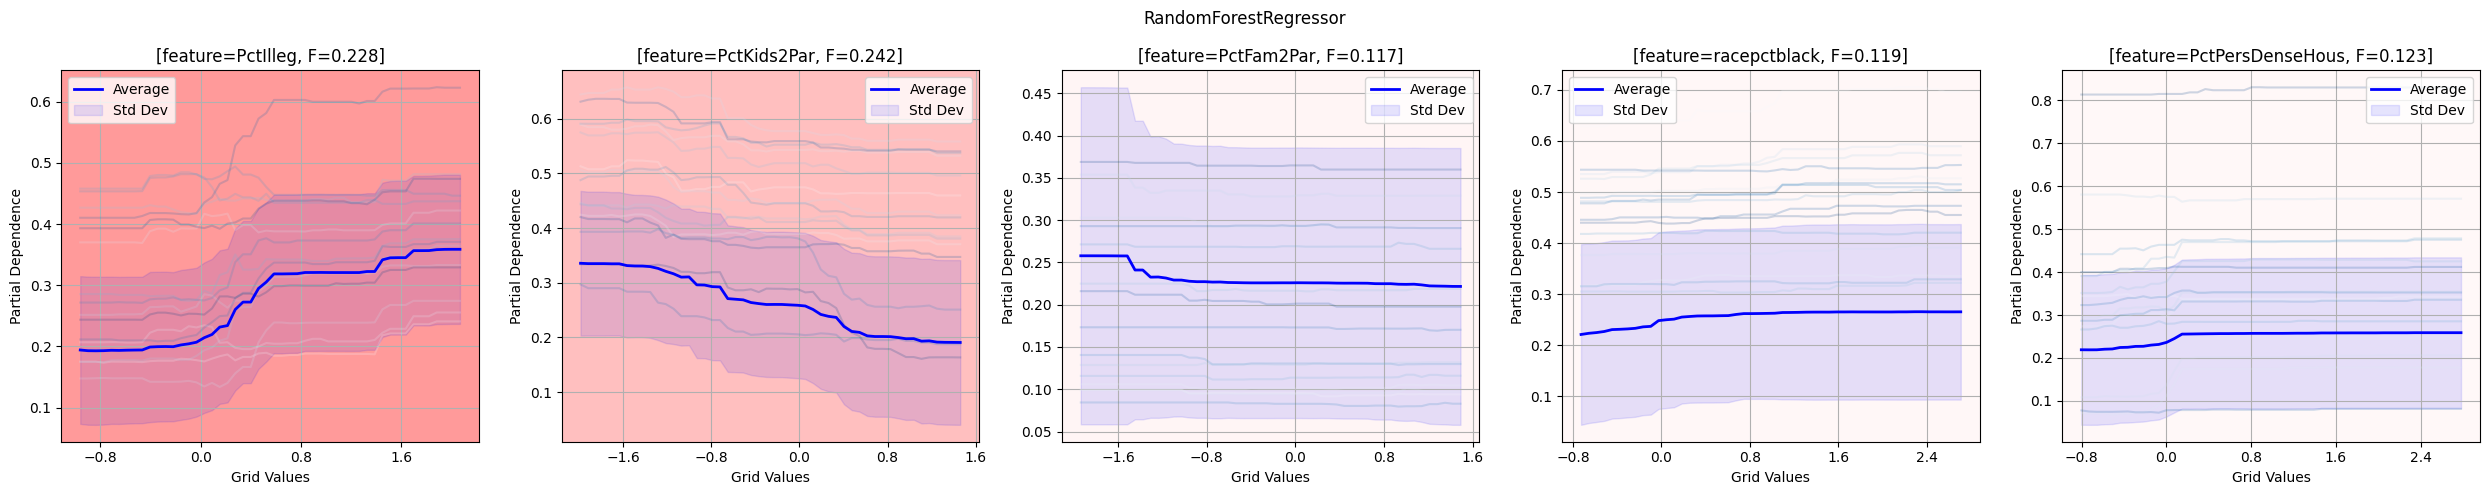

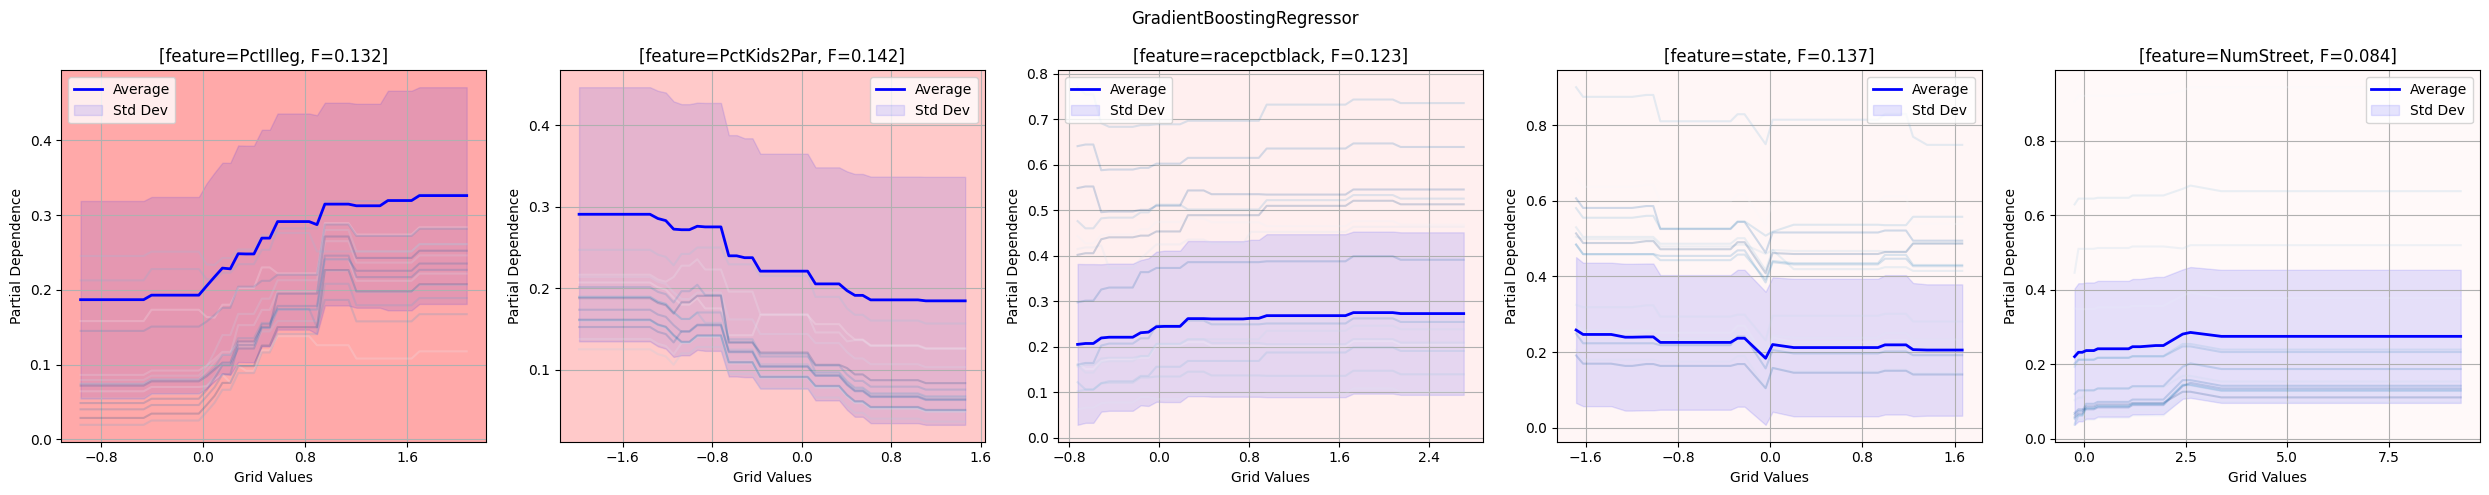

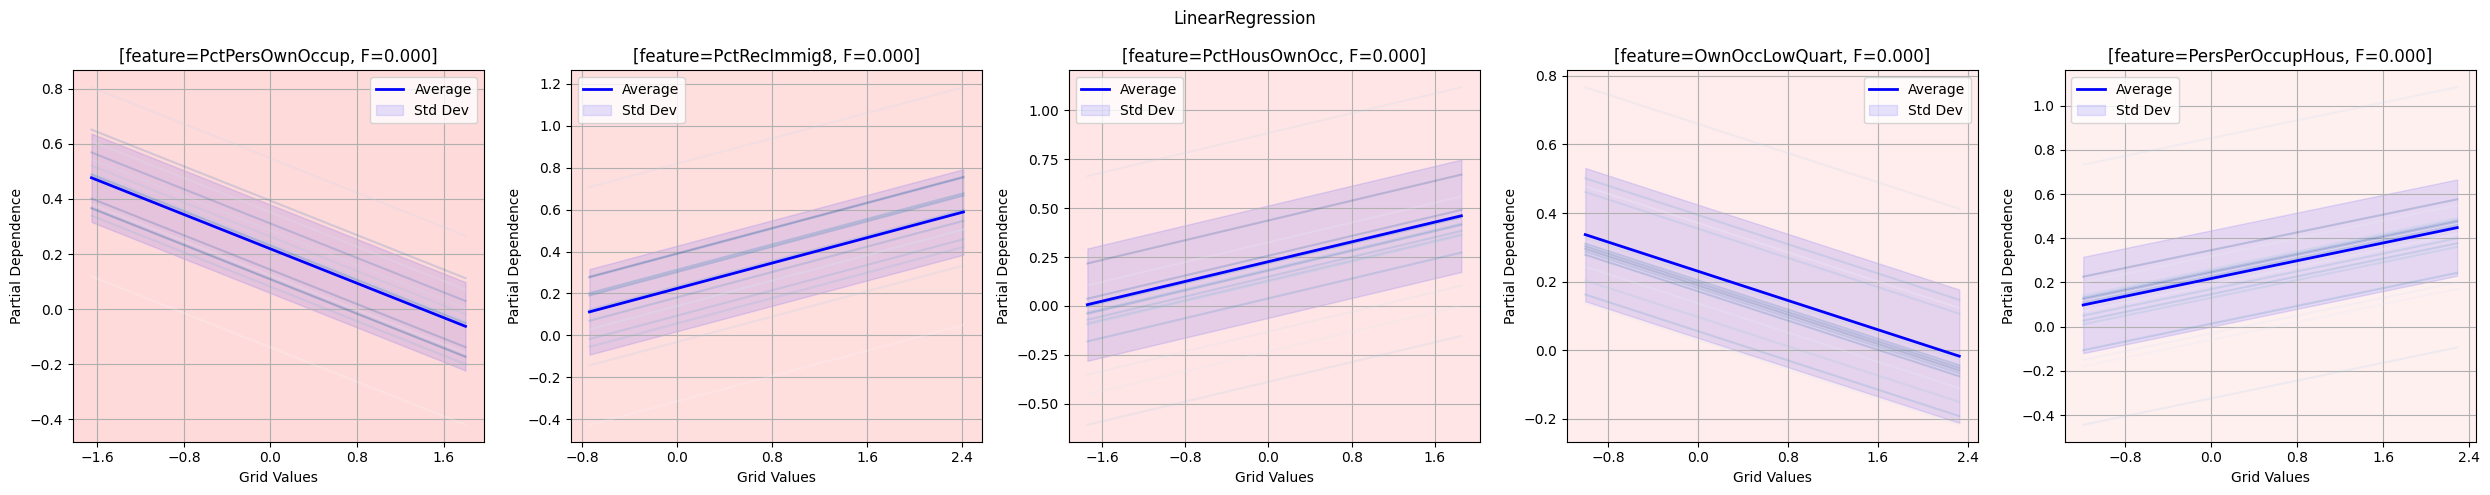

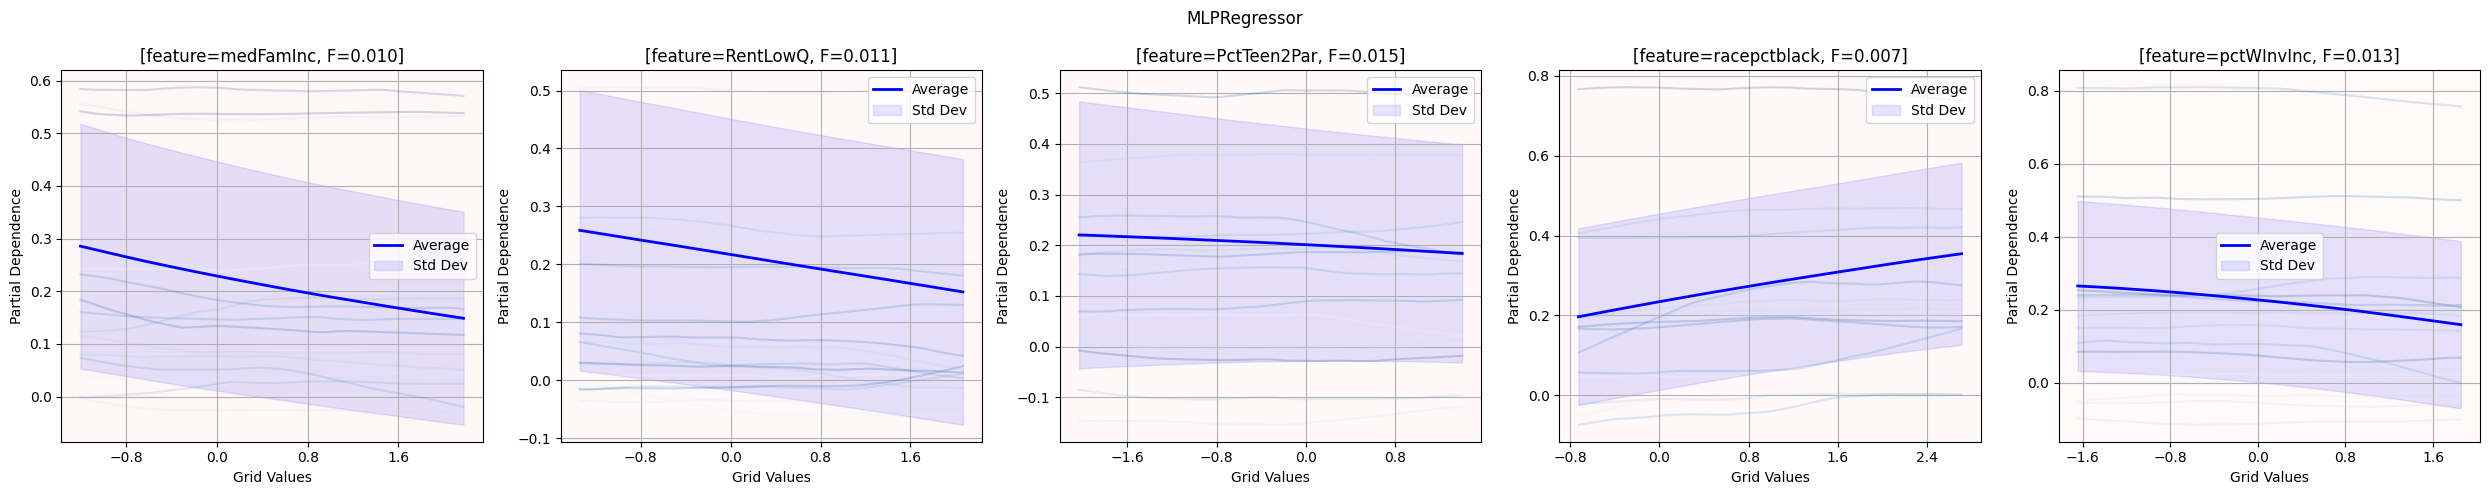

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import os

top_n = 5
figsize=(25,5)
for model_name, result in results.items():
    os.makedirs(model_name, exist_ok=True)
    plot_explainable_partial_dependence(result['partial_dependencies'], 
                                        result['importances'], 
                                        figsize=figsize, 
                                        feature_names=result['partial_dependencies'].feature_names, 
                                        model_name=model_name, 
                                        label=0, 
                                        top_n=top_n)
    plt.show()

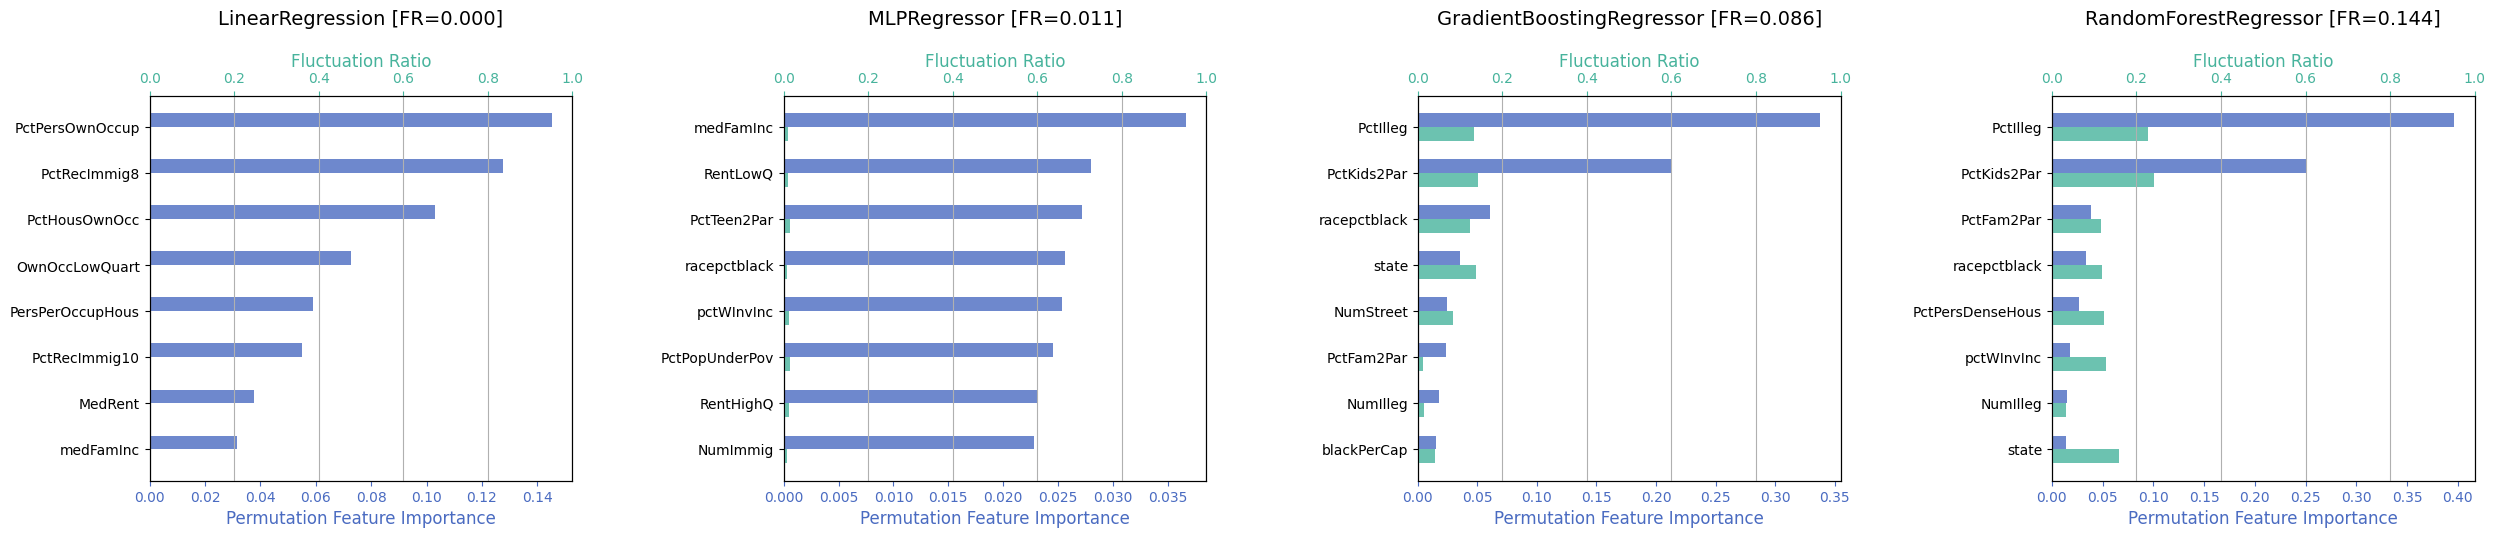

In [33]:
model_names = ["LinearRegression", "MLPRegressor", "GradientBoostingRegressor", "RandomForestRegressor"]
top_n=8
plt.figure(figsize=(30, 5))
for i,model_name in enumerate(model_names):
    plt.subplot(1,4,i+1)
    result = results[model_name]
    plot_top_explainable_global_feature_importances(result['partial_dependencies'], result['importances'], model_name, top_n)

# Local Feature Importance

### Local Feature Importance Analysis

In [27]:
local_results = {}
for model_name,model in models.items():
    local_importances = compute_shap_feature_importance(X=Xt_train, proxy=model, max_samples=1000, random_state=42)
    local_results[model_name] = {'local_importances':local_importances}

PermutationExplainer explainer: 1001it [03:36,  4.45it/s]                          
PermutationExplainer explainer: 1001it [00:59, 13.92it/s]                          
PermutationExplainer explainer: 1001it [00:33, 21.24it/s]                         
PermutationExplainer explainer: 1001it [05:04,  3.16it/s]                          


### Local Feature Importance - Metrics

In [28]:
from holisticai.explainability.metrics.local_feature_importance import classification_local_feature_importance_explainability_metrics
metrics = {}
for model_name,result in local_results.items():
    metrics[model_name] = classification_local_feature_importance_explainability_metrics(result['local_importances'])

local_metrics = concatenate_metrics(metrics)
local_metrics

,RandomForestRegressor,GradientBoostingRegressor,LinearRegression,MLPRegressor,Reference
Rank Consistency,0.2093,0.1355,0.176072,0.27831,0
Importance Stability,0.023398,0.018404,0.011505,0.011018,0


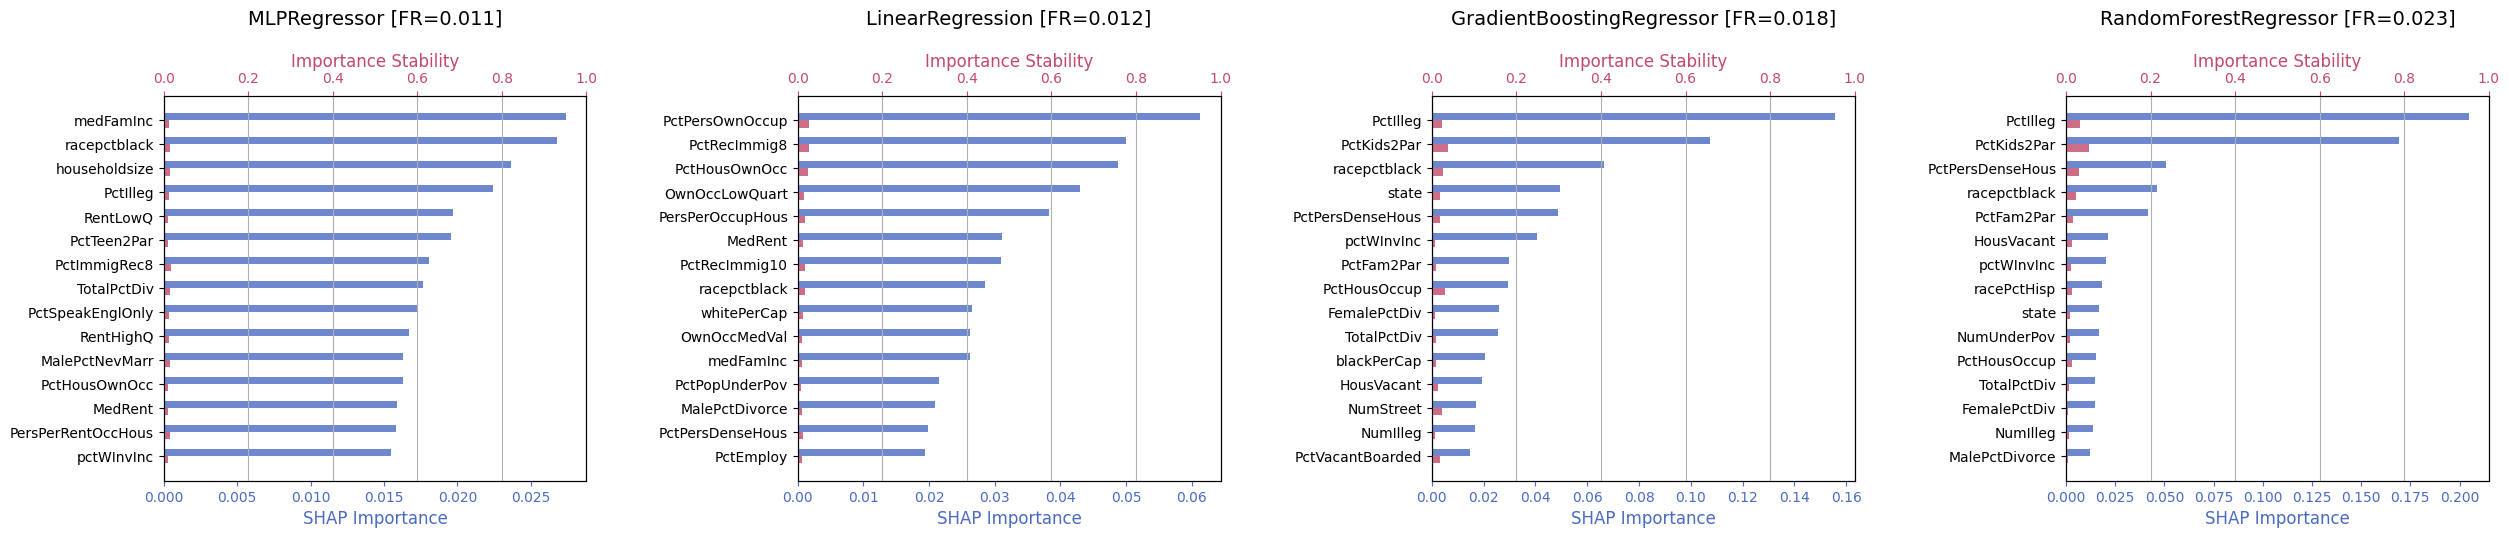

In [31]:
model_names = ["MLPRegressor", "LinearRegression", "GradientBoostingRegressor", "RandomForestRegressor"]

plt.figure(figsize=(30, 5))
top_n = 15
for i,model_name in enumerate(model_names):
    plt.subplot(1,4,i+1)
    plot_local_feature_importances_stability(local_results[model_name]['local_importances'], top_n=top_n, model_name=model_name)

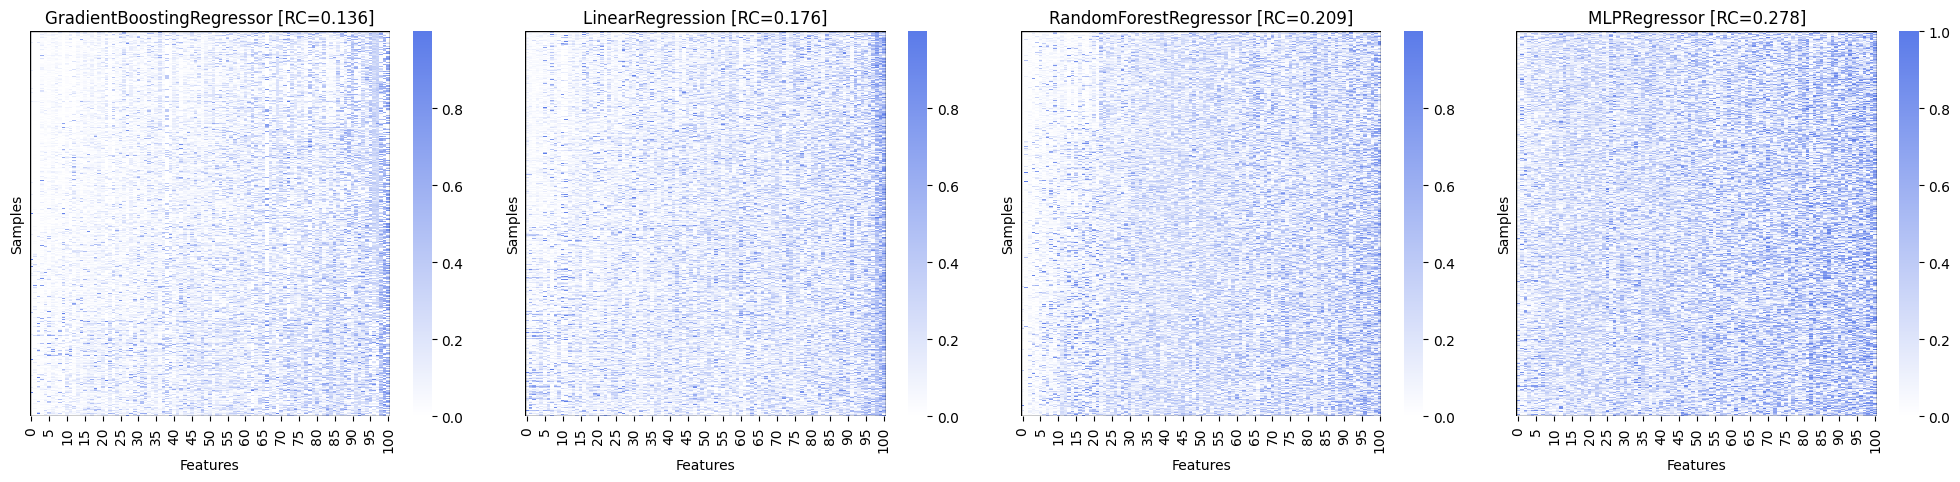

In [35]:
model_names = ["GradientBoostingRegressor", "LinearRegression", "RandomForestRegressor", "MLPRegressor"]
plt.figure(figsize=(25, 5))
for i, model_name in enumerate(model_names):
    result = local_results[model_name]
    plt.subplot(1, 4, i+1)
    plot_ranking_consistency(result['local_importances'], model_name)

In [36]:
surrogates = {}
for model_name,model in models.items():
    y_pred = model.predict(Xt_train)    
    surrogate = create_surrogate_model(Xt_train, y_pred, surrogate_type="shallow_tree", learning_task="regression")
    surrogates[model_name] = surrogate

# Surrogate Analysis - Metrics

In [37]:
from holisticai.explainability.metrics.surrogate import regression_surrogate_explainability_metrics

metrics = {}
for model_name,surrogate in surrogates.items():
    y_pred = models[model_name].predict(Xt_test)
    metrics[model_name] = regression_surrogate_explainability_metrics(Xt_test, yt_test, y_pred, surrogate)
xai_surrogate_metrics = concatenate_metrics(metrics)

# Surrogate Analysis

In [38]:
efficacy_metrics

,RandomForestRegressor,GradientBoostingRegressor,LinearRegression,MLPRegressor,Reference
Metric,,,,,
RMSE,1.408874e-01,1.384504e-01,1.379333e-01,1.811699e-01,0
MAE,9.272832e-02,8.910907e-02,9.460668e-02,1.304056e-01,0
MAPE,1.088088e+12,1.374844e+12,1.525648e+12,7.429251e+11,0
Max Error,7.731000e-01,7.582146e-01,7.425855e-01,8.954089e-01,0
SMAPE,2.389836e-01,2.340160e-01,2.858878e-01,4.025374e-01,0


In [39]:
global_metrics

,RandomForestRegressor,GradientBoostingRegressor,LinearRegression,MLPRegressor,Reference
Spread Divergence,0.717439,0.69382,0.67329,0.343823,1
Fluctuation Ratio,0.143838,0.085692,0.0,0.011256,0
Rank Alignment,0.196023,0.278413,0.705556,0.429885,1
Alpha Score,0.089109,0.138614,0.158416,0.49505,0


In [40]:
xai_surrogate_metrics

,RandomForestRegressor,GradientBoostingRegressor,LinearRegression,MLPRegressor,Reference
MSE Degradation,0.27182,0.227878,0.300468,0,0
Surrogate Fidelity,0.76266,0.769925,0.674494,0.4799,1
Surrogate Feature Stability,0.489087,0.270303,0.338254,0.202348,1


In [41]:
local_metrics

,RandomForestRegressor,GradientBoostingRegressor,LinearRegression,MLPRegressor,Reference
Rank Consistency,0.2093,0.1355,0.176072,0.27831,0
Importance Stability,0.023398,0.018404,0.011505,0.011018,0


In [42]:
import pandas as pd
metrics = {'global':global_metrics, 'local':local_metrics, 'surrogate':xai_surrogate_metrics}
dataframes = []
for metric_type,metric in metrics.items():
    metric['metric_type'] = metric_type
    dataframes.append(metric)
df = pd.concat(dataframes, axis=0)
df

,RandomForestRegressor,GradientBoostingRegressor,LinearRegression,MLPRegressor,Reference,metric_type
Spread Divergence,0.717439,0.69382,0.67329,0.343823,1,global
Fluctuation Ratio,0.143838,0.085692,0.0,0.011256,0,global
Rank Alignment,0.196023,0.278413,0.705556,0.429885,1,global
Alpha Score,0.089109,0.138614,0.158416,0.49505,0,global
Rank Consistency,0.2093,0.1355,0.176072,0.27831,0,local
Importance Stability,0.023398,0.018404,0.011505,0.011018,0,local
MSE Degradation,0.27182,0.227878,0.300468,0,0,surrogate
Surrogate Fidelity,0.76266,0.769925,0.674494,0.4799,1,surrogate
Surrogate Feature Stability,0.489087,0.270303,0.338254,0.202348,1,surrogate


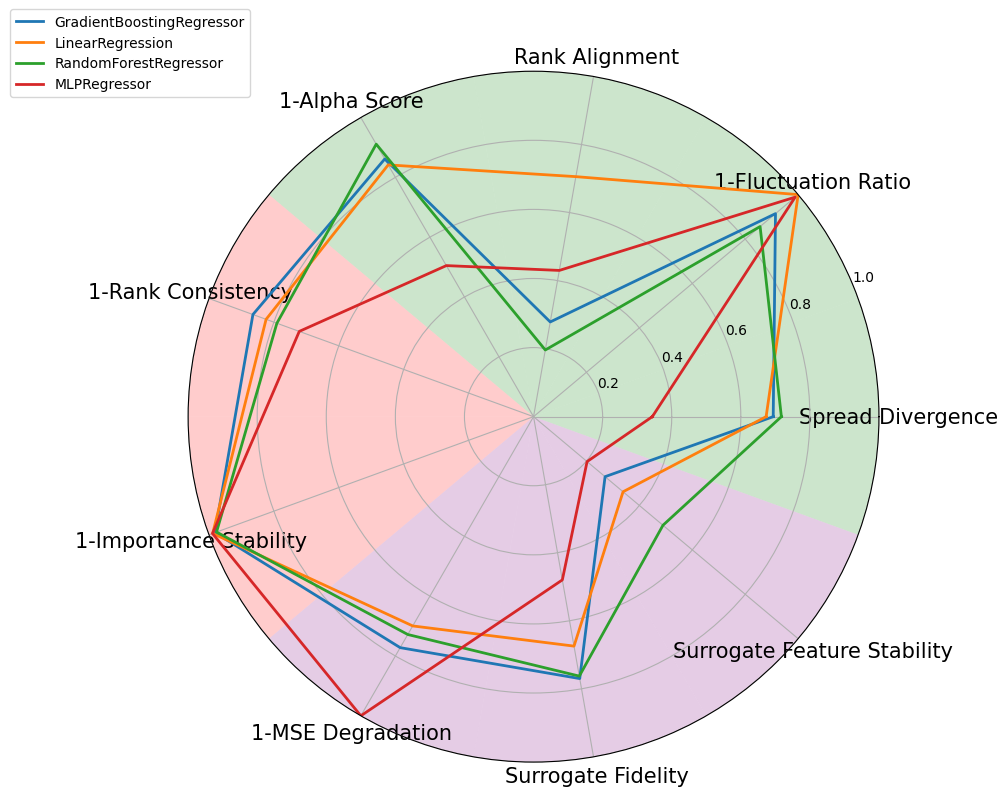

In [43]:
plot_radar_metrics(df, model_names)
plt.show()